## Initial setup

In [2]:
# Load necessary libraries
library(tidyverse)
library(syuzhet)
library(wordcloud)
library(tidytext)
library(readxl)
library(tm)

# Load the provided survey data
file_path <- "data/cleanSurveyData20240514.xlsx"
survey_data <- read_excel(file_path)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.0     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Indlaeser kraevet pakke: RColorBrewer

Indlaeser kraevet pakke: NLP


Vedhaefter pakke: 'NLP'


Det folgende objekt er maskeret fra 'package:ggplot2':

    annotate




### Show the column names + index number (survey questions)
From here on we can use the index numbers to refer to the questions.

In [3]:
# Display the column names
print(colnames(survey_data))

 [1] "ID"                                                                                                       
 [2] "Start time"                                                                                               
 [3] "Completion time"                                                                                          
 [4] "Email"                                                                                                    
 [5] "Do you consider yourself a professional or a hobbyist in game development?"                               
 [6] "Primary area of work?"                                                                                    
 [7] "Years of experience in game development?"                                                                 
 [8] "Are you in a lead role?"                                                                                  
 [9] "Team size?"                                                                               

## Count of Professionals vs. Hobbyists

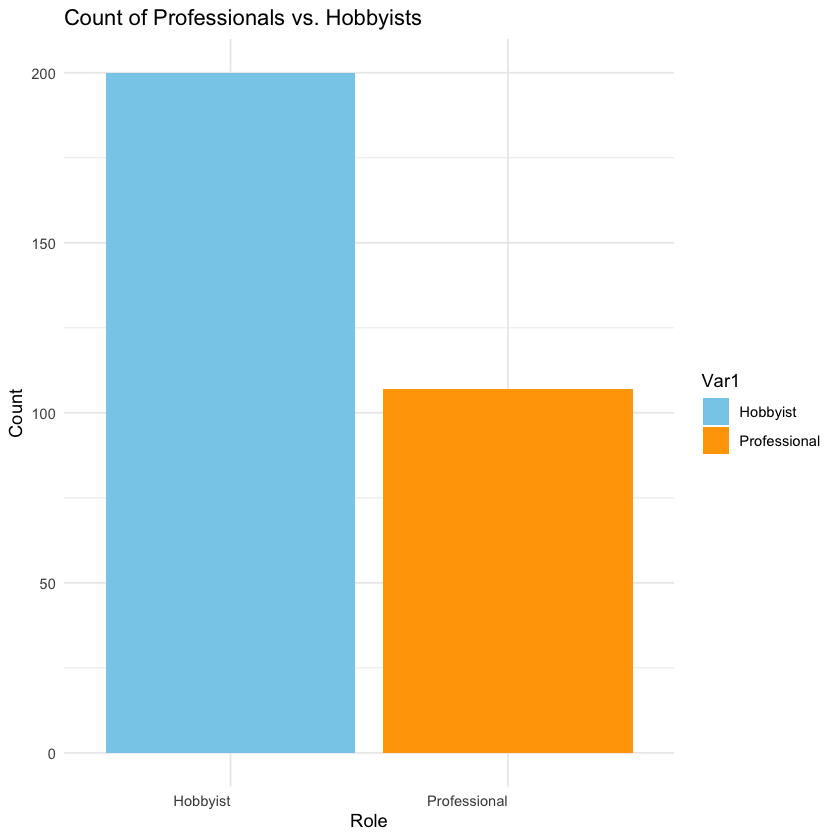

In [4]:
# Fill missing values in 'Do you consider yourself a professional or a hobbyist in game development?'
survey_data[[5]][is.na(survey_data[[5]])] <- "Unknown"

# Descriptive analysis: Count of professionals vs. hobbyists
professional_hobbyist_count <- table(
    survey_data[[5]]
)

# Plotting the count of professionals vs. hobbyists
ggplot(as.data.frame(professional_hobbyist_count), aes(x = Var1, y = Freq, fill = Var1)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(title = "Count of Professionals vs. Hobbyists", x = "Role", y = "Count") +
  theme(axis.text.x = element_text(angle = 0, hjust = 1)) +
  scale_fill_manual(values = c(
    "skyblue", 
    "orange"
    )
    ) # Added more colors to the scale


## Primary area of work

In [5]:
# Show the distribution of 'Primary area of work?' in number of respondents
primary_area_count <- table(survey_data[6])

# Print the raw count of respondents in each primary area of work
primary_area_count

Primary area of work?
                                                                                                                                                                                     Art & Assets 
                                                                                                                                                                                               35 
                                                                                                                                                                                    Audio & Music 
                                                                                                                                                                                                3 
                                                                                                                                                                                   Auto body, lol 
   

### Manual clean up of categories

In [6]:
# Generalists
for (i in c(7, 9, 11, 12)) { # Combine the categories
    primary_area_count[8] <- primary_area_count[8] + primary_area_count[i]
}

# Rename to Generalists
names(primary_area_count)[8] <- "Generalists"

# Other
for (i in c(3, 4, 6, 14)) { # Combine the categories
    primary_area_count[15] <- primary_area_count[15] + primary_area_count[i]
}

# Rename to Other
names(primary_area_count)[15] <- "Other"

# Remove the categories that were combined
primary_area_count <- primary_area_count[-c(7, 9, 11, 12, 3, 4, 6, 14)]

# Output the cleaned up categories
primary_area_count

           Art & Assets           Audio & Music     Design & Production 
                     35                       3                      13 
            Generalists          Marketing & PR Technical & Programming 
                    138                       1                     112 
                  Other 
                      5 

### Visualizing the data

Warning message in dotchart(primary_area_count, labels = paste(names(primary_area_count), :
"'x' is neither a vector nor a matrix: using as.numeric(x)"


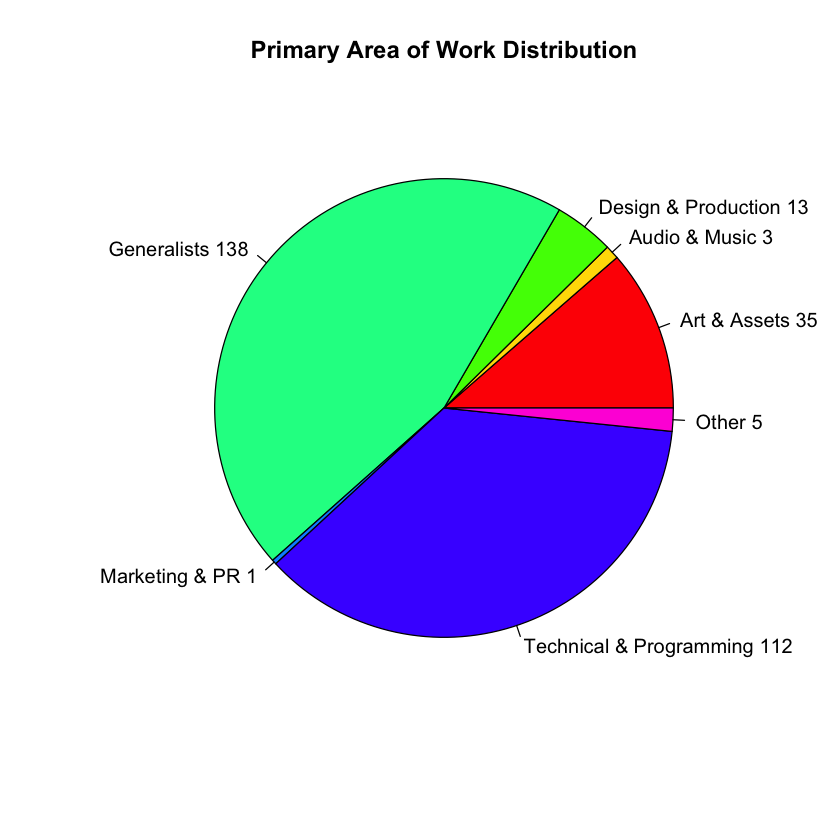

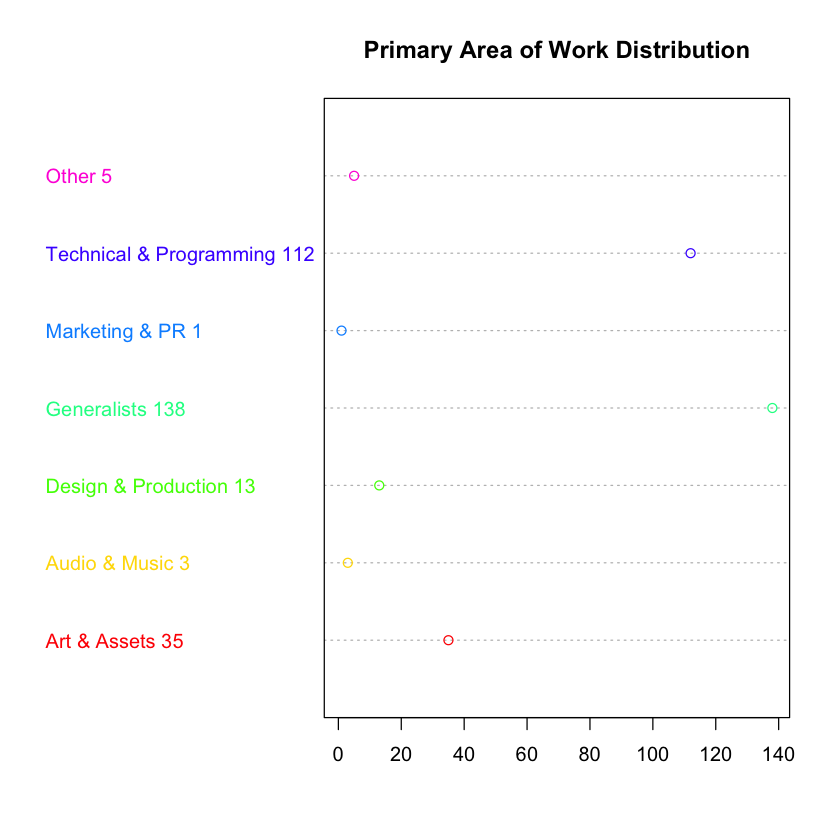

In [7]:
# Distribution of primary areas of work
pie(
    primary_area_count,
    labels = paste(names(primary_area_count), primary_area_count),
    main = "Primary Area of Work Distribution",
    col = rainbow(length(primary_area_count))
)



# And as a dotchart
dotchart(
    primary_area_count,
    labels = paste(names(primary_area_count), primary_area_count),
    main = "Primary Area of Work Distribution",
    col = rainbow(length(primary_area_count))
)

## Distribution of Years of Experience

  [1] "0-1 years"        NA                 "2-4 years"       
  [4] "20 years or more" NA                 "15-19 years"     
  [7] NA                 NA                 NA                
 [10] "2-4 years"        NA                 NA                
 [13] "5-9 years"        "5-9 years"        "0-1 years"       
 [16] NA                 "10-14 years"      NA                
 [19] "10-14 years"      NA                 NA                
 [22] "5-9 years"        NA                 "5-9 years"       
 [25] NA                 NA                 NA                
 [28] NA                 "0-1 years"        NA                
 [31] NA                 NA                 "5-9 years"       
 [34] NA                 NA                 NA                
 [37] NA                 NA                 NA                
 [40] NA                 "5-9 years"        NA                
 [43] NA                 "2-4 years"        NA                
 [46] "2-4 years"        NA                 "2-4 years"

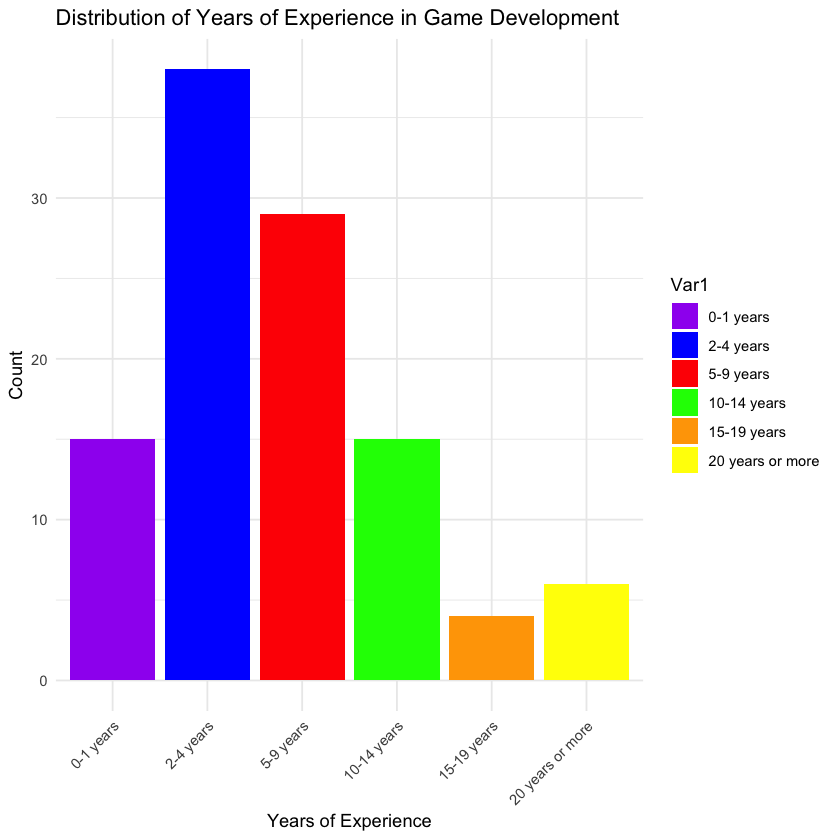

In [8]:
# Define the correct order for the levels
year_levels <- c("0-1 years", "2-4 years", "5-9 years", "10-14 years", "15-19 years", "20 years or more")

print(survey_data[[7]])

# Convert the Years of experience column to a factor with specified levels
survey_data[[7]] <- factor(survey_data[[7]], levels = year_levels)

# Filter out 'Unknown' values
filtered_survey_data <- survey_data[!is.na(survey_data[[7]]), ]

# Descriptive analysis: Distribution of years of experience
experience_distribution <- table(filtered_survey_data[[7]])

# Plotting the distribution of years of experience
ggplot(as.data.frame(experience_distribution), aes(x = Var1, y = Freq, fill = Var1)) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(
    title = "Distribution of Years of Experience in Game Development", 
    x = "Years of Experience", 
    y = "Count"
    ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_fill_manual(values = c(
    "purple", 
    "blue", 
    "red", 
    "green", 
    "orange",
    "yellow"
    )
)


## Overall Stance on Generative AI

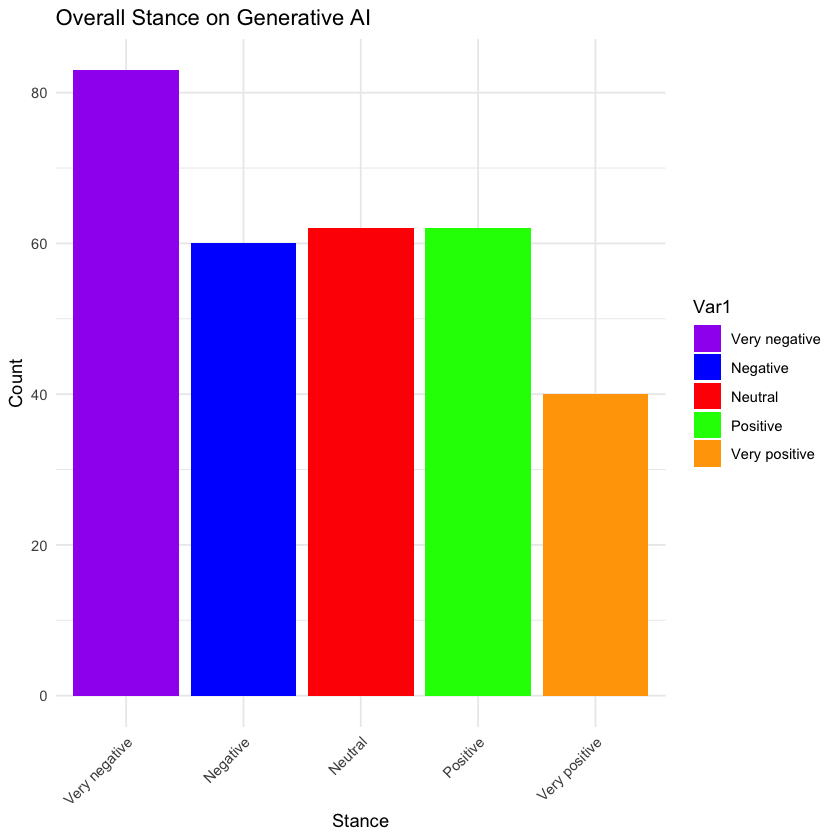

In [9]:
# Define the correct order for the levels
stance_levels <- c(
    "Very negative",
    "Negative",
    "Neutral",
    "Positive",
    "Very positive"
)

# Convert the 'Overall stance on Generative AI?2'
# column to a factor with specified levels
survey_data[[10]] <- factor(survey_data[[10]], levels = stance_levels)

# Exclude 'Unknown' values
filtered_survey_data <- survey_data[!is.na(survey_data[[10]]), ]

# Descriptive analysis: Overall stance on Generative AI
stance_distribution <- table(filtered_survey_data[[10]])

# Plotting the overall stance on Generative AI
ggplot(
    as.data.frame(stance_distribution), 
    aes(x = Var1, y = Freq, fill = Var1)
    ) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(title = "Overall Stance on Generative AI", x = "Stance", y = "Count") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_fill_manual(
    values = c(
        "purple", 
        "blue", 
        "red", 
        "green", 
        "orange"
    )
)


## Correlation Analysis

In [10]:
# Convert categorical data to numeric for correlation analysis
survey_data_numeric <- survey_data %>%
  mutate(
    YearsExperience = case_when(
      .[[7]] == "0-1 years" ~ 1,
      .[[7]] == "2-4 years" ~ 2,
      .[[7]] == "5-9 years" ~ 3,
      .[[7]] == "10-14 years" ~ 4,
      .[[7]] == "15-19 years" ~ 5,
      .[[7]] == "20 years or more" ~ 6,
      TRUE ~ 0
    ),
    StanceOnGenAI = case_when(
      .[[10]] == "Very positive" ~ 5,
      .[[10]] == "Positive" ~ 4,
      .[[10]] == "Neutral" ~ 3,
      .[[10]] == "Negative" ~ 2,
      .[[10]] == "Very negative" ~ 1,
      TRUE ~ 0
    )
  )

# Calculate correlation
correlation <- cor(
    survey_data_numeric$YearsExperience,
    survey_data_numeric$StanceOnGenAI,
    method = "spearman",
    use = "complete.obs"
)

print(correlation)


[1] -0.08107992


noter til corelation
The correlation coefficient of -0.055264 indicates a very weak negative linear relationship between the years of experience in game development and the overall stance on Generative AI among the survey respondents. Here's a more detailed interpretation:

Interpretation:
Magnitude:

The value of -0.055264 is very close to 0, which suggests that there is almost no linear relationship between the two variables.
Direction:

The negative sign indicates that, as the years of experience increase, there is a slight tendency for the stance on Generative AI to become more negative. However, this tendency is very weak.
Practical Significance:

Given the small magnitude of the correlation coefficient, it is unlikely that this relationship has practical significance. In other words, years of experience in game development do not meaningfully predict the overall stance on Generative AI based on the survey data.

## Sentiment Analysis

### Wordcloud

#### "What do you think will be the most promising innovations from Generative AI in game development?" 

Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
"transformation drops documents"


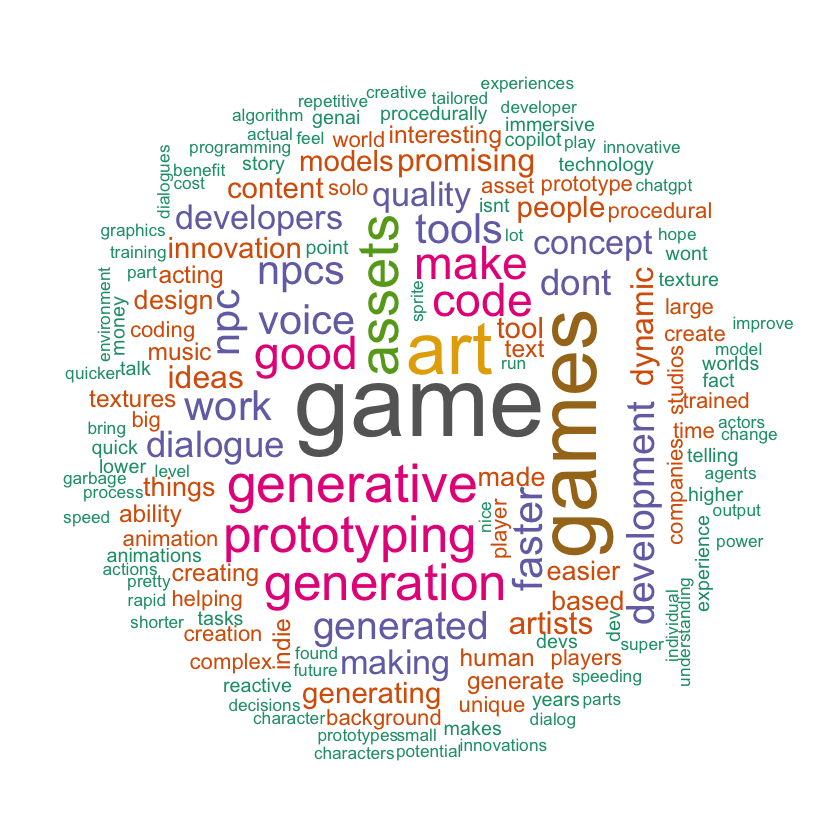

In [11]:
# Preprocess the text data
survey_data[[45]] <- iconv(survey_data[[45]], "latin1", "UTF-8") # Convert to UTF-8
survey_data[[45]] <- tolower(survey_data[[45]]) # Convert to lowercase
survey_data[[45]] <- removePunctuation(survey_data[[45]]) # Remove punctuation
survey_data[[45]] <- removeNumbers(survey_data[[45]]) # Remove numbers
survey_data[[45]] <- removeWords(survey_data[[45]], stopwords("smart")) # Remove stopwords
survey_data[[45]] <- stripWhitespace(survey_data[[45]]) # Remove extra whitespaces

# Create a wordcloud
wordcloud(
    survey_data[[45]],
    colors = brewer.pal(8, "Dark2"),
    random.order = FALSE,
    scale = c(5, 0.5),
    max.words = 250
)

# Show how many times each word appears
#word_freq <- table(unlist(strsplit(survey_data[[45]], " ")))
#word_freq <- sort(word_freq, decreasing = TRUE)
#head(decreasing = TRUE, word_freq, 200)

#### "What do you think will be the most negative consequences of Generative AI in game development?"

Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
"transformation drops documents"
Warning message in strwidth(words[i], cex = size[i], ...):
"skriftbredde ukendt for tegn 0x0"
Warning message in strwidth(words[i], cex = size[i], ...):
"skriftbredde ukendt for tegn 0x0"
Warning message in text.default(x1, y1, words[i], cex = size[i], offset = 0, srt = rotWord * :
"skriftbredde ukendt for tegn 0x0"
Warning message in text.default(x1, y1, words[i], cex = size[i], offset = 0, srt = rotWord * :
"skriftbredde ukendt for tegn 0x0"
Warning message in text.default(x1, y1, words[i], cex = size[i], offset = 0, srt = rotWord * :
"maleenhed for skrifttype er ukendt for tegn 0x80"
Warning message in text.default(x1, y1, words[i], cex = size[i], offset = 0, srt = rotWord * :
"maleenhed for skrifttype er ukendt for tegn 0x99"


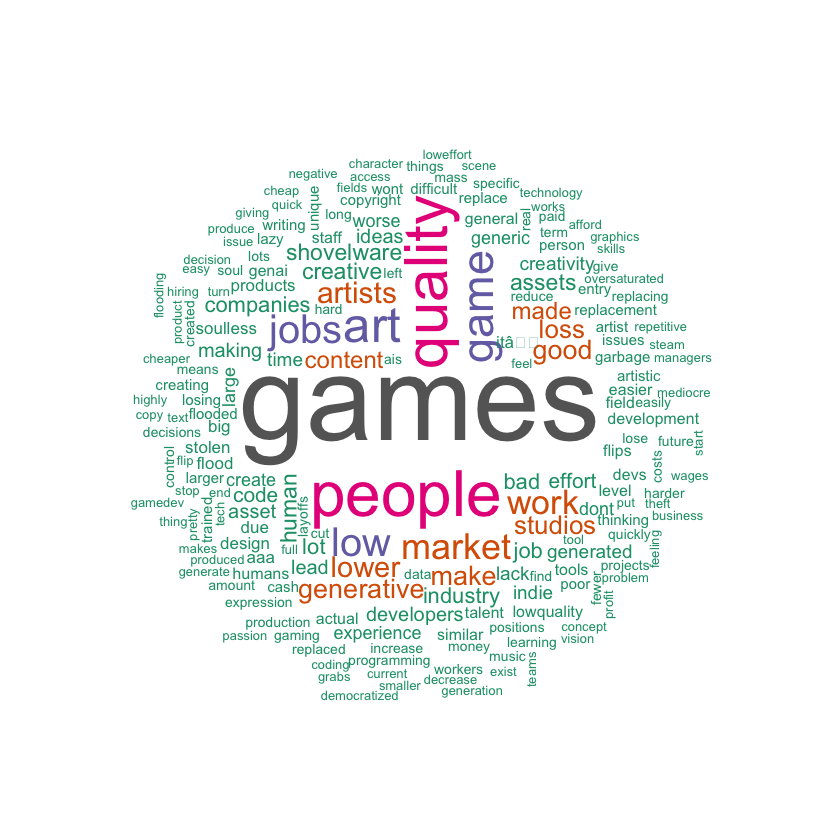

In [12]:
# wordcloud
# Preprocess the text data
survey_data[[46]] <- iconv(survey_data[[46]], "latin1", "UTF-8") # Convert to UTF-8
survey_data[[46]] <- tolower(survey_data[[46]]) # Convert to lowercase
survey_data[[46]] <- removePunctuation(survey_data[[46]]) # Remove punctuation
survey_data[[46]] <- removeNumbers(survey_data[[46]]) # Remove numbers
survey_data[[46]] <- removeWords(survey_data[[46]], stopwords("smart")) # Remove stopwords
survey_data[[46]] <- stripWhitespace(survey_data[[46]]) # Remove extra whitespaces

# Create a wordcloud
wordcloud(
    survey_data[[46]],
    colors = brewer.pal(8, "Dark2"),
    random.order = FALSE,
    scale = c(6, .5),
    max.words = 250
)

# Show how many times each word appears
#word_freq <- table(unlist(strsplit(survey_data[[46]], " ")))
#word_freq <- sort(word_freq, decreasing = TRUE)
#head(decreasing = TRUE, word_freq, 200)

       anger anticipation      disgust         fear          joy      sadness 
          23           87           22           28           85           48 
    surprise        trust     negative     positive 
          63          100           66          234 


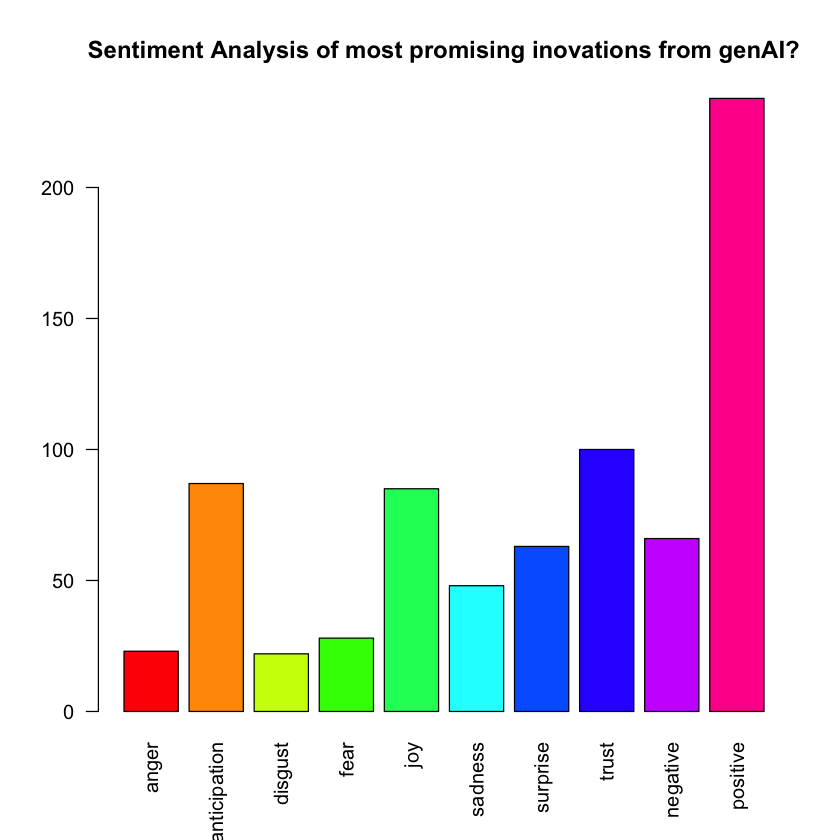

In [13]:
# Extract open-ended responses
open_ended_responses <- survey_data[[45]]
# print(open_ended_responses)

# Perform sentiment analysis
sentiment_scores_0 <- get_nrc_sentiment(open_ended_responses)
# print(sentiment_scores_0)

# Summarize sentiment scores
sentiment_summary_0 <- colSums(sentiment_scores_0)
print(sentiment_summary_0)

# Plot sentiment scores
barplot(
    sentiment_summary_0, 
    las = 2, 
    col = rainbow(10), 
    main = "Sentiment Analysis of most promising inovations from genAI?"
)


       anger anticipation      disgust         fear          joy      sadness 
          89          143           71          107          119          147 
    surprise        trust     negative     positive 
          83          137          226          329 


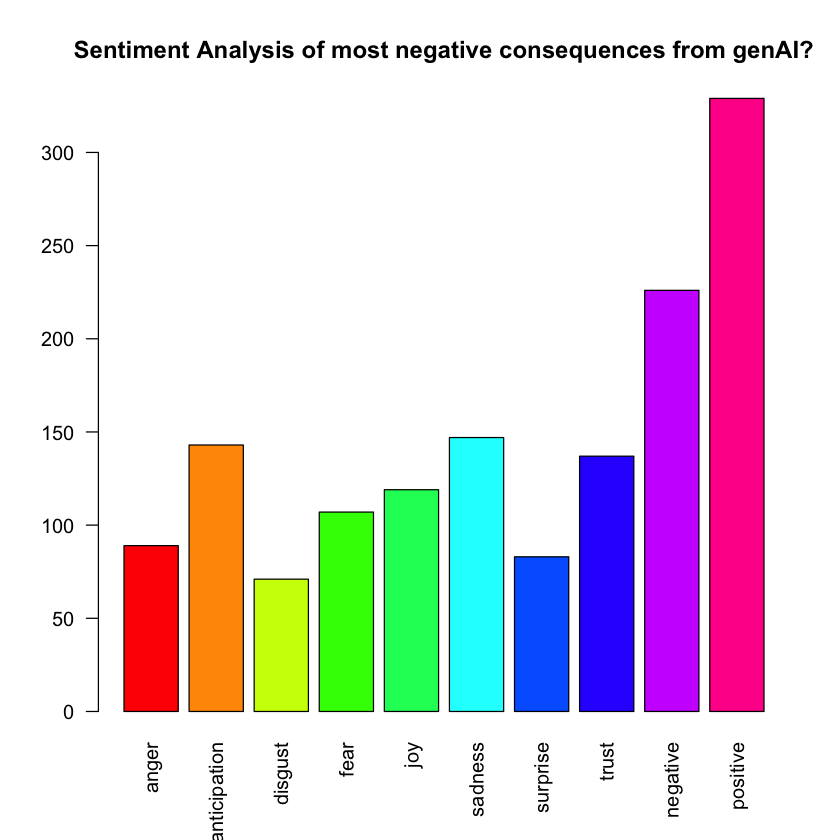

In [14]:
# Extract open-ended responses
open_ended_responses <- survey_data[[46]]

# Perform sentiment analysis
sentiment_scores_1 <- get_nrc_sentiment(open_ended_responses)

# Summarize sentiment scores
sentiment_summary_1 <- colSums(sentiment_scores_1)
print(sentiment_summary_1)

# Plot sentiment scores
barplot(
    sentiment_summary_1, 
    las = 2, 
    col = rainbow(10), 
    main = "Sentiment Analysis of most negative consequences from genAI?"
)

       anger anticipation      disgust         fear          joy      sadness 
          24           96           25           36           94           56 
    surprise        trust     negative     positive 
          42          117           75          276 


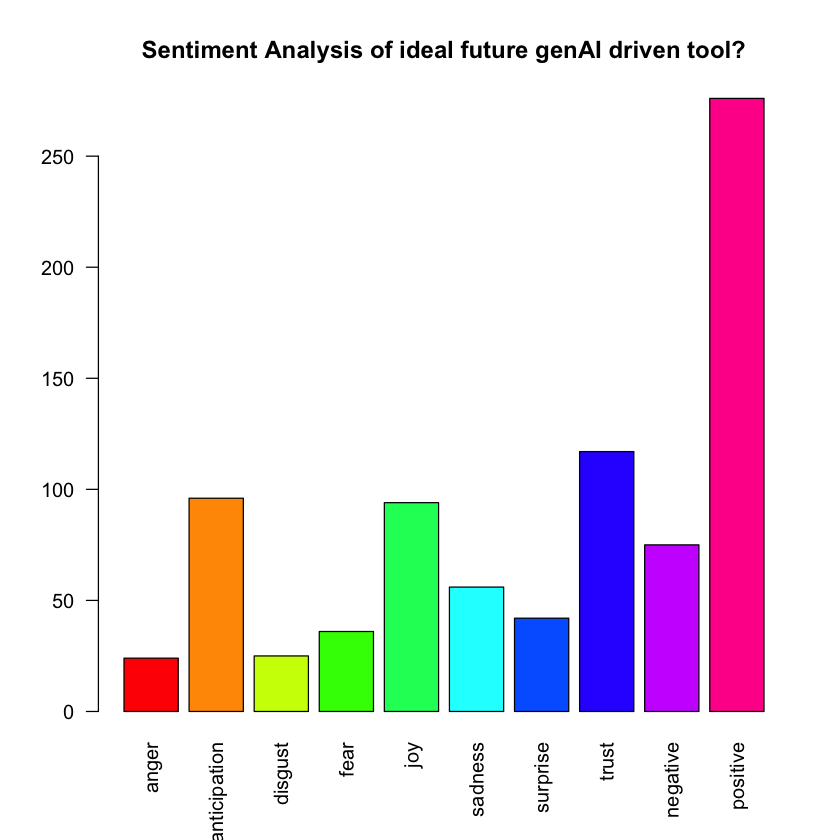

In [15]:
# Extract open-ended responses
open_ended_responses <- survey_data[[50]]

# Perform sentiment analysis
sentiment_scores_2 <- get_nrc_sentiment(open_ended_responses)

# Summarize sentiment scores
sentiment_summary_2 <- colSums(sentiment_scores_2)
print(sentiment_summary_2)

# Plot sentiment scores
barplot(
    sentiment_summary_2,
    las = 2,
    col = rainbow(10),
    main = "Sentiment Analysis of ideal future genAI driven tool?"
)


       anger anticipation      disgust         fear          joy      sadness 
          23           59           26           32           43           44 
    surprise        trust     negative     positive 
          29           74           58          145 


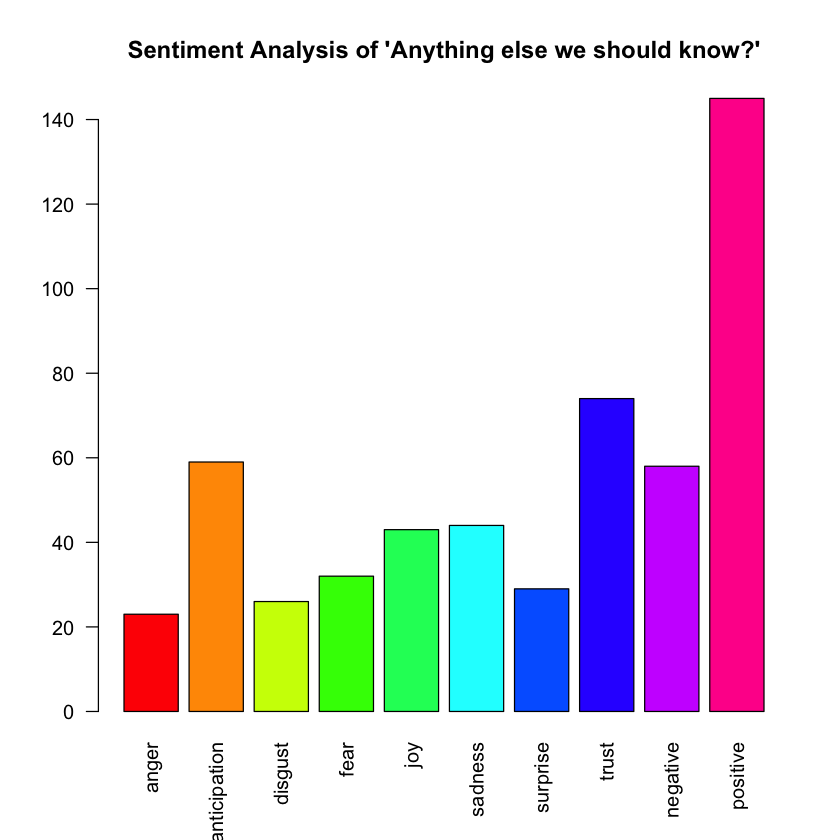

In [16]:
# Extract open-ended responses
open_ended_responses <- survey_data[[52]]

# Perform sentiment analysis
sentiment_scores_3 <- get_nrc_sentiment(open_ended_responses)

# Summarize sentiment scores
sentiment_summary_3 <- colSums(sentiment_scores_3)
print(sentiment_summary_3)

# Plot sentiment scores
barplot(
    sentiment_summary_3,
    las = 2,
    col = rainbow(10),
    main = "Sentiment Analysis of 'Anything else we should know?'"
)


## Group Comparisons

[1] "Average stance on GenAI for professionals: 2.5981308411215"
[1] "Average stance on GenAI for hobbyists: 2.795"

	Welch Two Sample t-test

data:  professionals$StanceOnGenAI and hobbyists$StanceOnGenAI
t = -1.1712, df = 210.38, p-value = 0.2428
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.5282309  0.1344926
sample estimates:
mean of x mean of y 
 2.598131  2.795000 



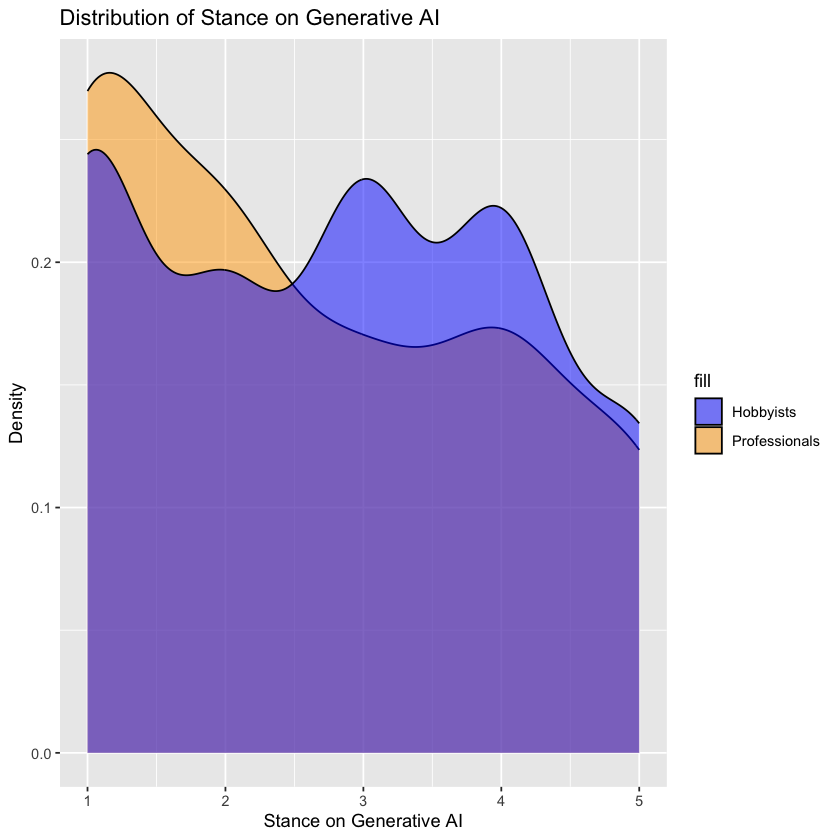

In [17]:
# Define the correct order for the levels
stance_levels <- c(
    "Very negative",
    "Negative",
    "Neutral",
    "Positive",
    "Very positive"
)

# Convert the 'Overall stance on GenAI' column to a factor with specified levels
survey_data[[10]] <- factor(survey_data[[10]], levels = stance_levels)

# Convert categorical data to numeric for stance on Generative AI
survey_data <- survey_data %>%
  mutate(
    StanceOnGenAI = case_when(
      .[[10]] == "Very positive" ~ 5,
      .[[10]] == "Positive" ~ 4,
      .[[10]] == "Neutral" ~ 3,
      .[[10]] == "Negative" ~ 2,
      .[[10]] == "Very negative" ~ 1,
      TRUE ~ NA_real_
    )
  )

# Filter data for professionals and hobbyists
professionals <- survey_data %>% filter(survey_data[[5]] == "Professional")
hobbyists <- survey_data %>% filter(survey_data[[5]] == "Hobbyist")

# Calculate average stance on Generative AI
avg_stance_professionals <- mean(professionals$StanceOnGenAI, na.rm = TRUE)
avg_stance_hobbyists <- mean(hobbyists$StanceOnGenAI, na.rm = TRUE)

print(
    paste(
        "Average stance on GenAI for professionals:",
        avg_stance_professionals
    )
)
print(
    paste(
        "Average stance on GenAI for hobbyists:",
        avg_stance_hobbyists
    )
)

# Visualize the distribution of stance on Generative AI for professionals and hobbyists
ggplot() +
  geom_density(
    aes(x = professionals$StanceOnGenAI, fill = "Professionals"),
    alpha = 0.5
  ) +
  geom_density(
    aes(x = hobbyists$StanceOnGenAI, fill = "Hobbyists"),
    alpha = 0.5
  ) +
  labs(
    title = "Distribution of Stance on Generative AI",
    x = "Stance on Generative AI",
    y = "Density"
  ) +
  scale_fill_manual(values = c("blue", "orange"))

# Perform a t-test to compare the average stance on Generative AI between professionals and hobbyists
t_test_result <- t.test(
    professionals$StanceOnGenAI,
    hobbyists$StanceOnGenAI,
    alternative = "two.sided",
    mu = 0,
    conf.level = 0.95
)

print(t_test_result)


## SKITSE
Explanation:
Convert Stance to Numeric: The StanceOnGenAI variable is converted to numeric values for easier computation.
Filter Data: Separate the data into professionals and hobbyists based on their response.
Calculate Averages: Compute the average stance for both professionals and hobbyists, excluding any missing values.
This code will give you the average stance on Generative AI for both professionals and hobbyists, allowing you to compare the perspectives of these two groups.

Let's break down the results of the Welch Two Sample t-test and interpret what they tell us.

### Welch Two Sample t-test Results

1. **Test Statistic (t)**:
   - `t = -1.1712`: This is the t-statistic, which measures the difference between the sample means relative to the variability of the samples.

2. **Degrees of Freedom (df)**:
   - `df = 210.38`: The degrees of freedom for the test. Welch's t-test does not assume equal variances between the groups, so the degrees of freedom are adjusted accordingly.

3. **p-value**:
   - `p-value = 0.2428`: This is the probability of observing a test statistic as extreme as, or more extreme than, the observed value under the null hypothesis. A high p-value indicates that the observed difference is not statistically significant.

4. **Alternative Hypothesis**:
   - `alternative hypothesis: true difference in means is not equal to 0`: The test is checking if there is a significant difference between the means of the two groups.

5. **95 Percent Confidence Interval**:
   - `95 percent confidence interval: -0.5282309  0.1344926`: This interval estimates the range within which the true difference in means lies with 95% confidence. Since the interval includes 0, it suggests that there is no significant difference between the means.

6. **Sample Estimates**:
   - `mean of x = 2.598131`: The mean stance on GenAI for professionals.
   - `mean of y = 2.795000`: The mean stance on GenAI for hobbyists.

### Interpretation

1. **Difference in Means**:
   - The mean stance on GenAI for professionals is 2.598131, while for hobbyists, it is 2.795000. The difference in means is relatively small.

2. **Statistical Significance**:
   - The p-value of 0.2428 is greater than the common significance level (e.g., 0.05). This means we fail to reject the null hypothesis and conclude that there is no statistically significant difference in the mean stance on GenAI between professionals and hobbyists.

3. **Confidence Interval**:
   - The 95% confidence interval for the difference in means is from -0.5282309 to 0.1344926. Since this interval includes 0, it further supports the conclusion that there is no significant difference between the two groups.

### Summary

The Welch Two Sample t-test indicates that there is no statistically significant difference in the mean stance on GenAI between professionals and hobbyists. The p-value is high, and the confidence interval includes 0, both suggesting that any observed difference in means is likely due to random variation rather than a true difference.

### References

- Welch, B. L. (1947). The generalization of "Student's" problem when several different population variances are involved. *Biometrika*, 34(1-2), 28-35.
- R Core Team. (2021). *R: A language and environment for statistical computing*. R Foundation for Statistical Computing, Vienna, Austria. URL https://www.R-project.org/.

If you have more questions or need further clarification, feel free to ask!

## SKITSE

### 1. Erfaring vs. Holdning til Generativ AI

#### Dataforberedelse:
Først skal vi sikre, at dataene er i den rette form, og at kolonnerne er korrekt kodet.

```r
# Load necessary libraries
library(dplyr)
library(ggplot2)

# Antag, at survey_data er din data frame
# Konverter relevante kolonner til faktorer
survey_data <- survey_data %>%
  mutate(
    ExperienceGroup = factor(`Years of experience in game development?`),
    StanceOnGenAI = as.numeric(`Overall stance on Generative AI?2`)
  )
```

#### Boxplot:
Visualiser holdningen til Generativ AI for forskellige erfaringsgrupper ved hjælp af et boxplot.

```r
# Boxplot for Stance on GenAI vs. Experience Group
ggplot(survey_data, aes(x=ExperienceGroup, y=StanceOnGenAI, fill=ExperienceGroup)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title="Stance on Generative AI vs. Years of Experience",
       x="Years of Experience",
       y="Stance on Generative AI") +
  theme(axis.text.x=element_text(angle=45, hjust=1))
```

#### T-test:
For at teste om der er signifikante forskelle mellem grupperne, kan du bruge en ANOVA-test (Analysis of Variance).

```r
# ANOVA test for Stance on GenAI vs. Experience Group
anova_result <- aov(StanceOnGenAI ~ ExperienceGroup, data=survey_data)
summary(anova_result)
```

### 2. Jobrolle vs. Holdning til Generativ AI

#### Dataforberedelse:
Sørg for, at kolonnen for jobroller er korrekt kodet.

```r
# Konverter relevante kolonner til faktorer
survey_data <- survey_data %>%
  mutate(
    JobRole = factor(`Primary job role in game development?`),
    StanceOnGenAI = as.numeric(`Overall stance on Generative AI?2`)
  )
```

#### Boxplot:
Visualiser holdningen til Generativ AI for forskellige jobroller ved hjælp af et boxplot.

```r
# Boxplot for Stance on GenAI vs. Job Role
ggplot(survey_data, aes(x=JobRole, y=StanceOnGenAI, fill=JobRole)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title="Stance on Generative AI vs. Job Role",
       x="Job Role",
       y="Stance on Generative AI") +
  theme(axis.text.x=element_text(angle=45, hjust=1))
```

#### ANOVA-test:
For at teste om der er signifikante forskelle mellem grupperne, kan du bruge en ANOVA-test.

```r
# ANOVA test for Stance on GenAI vs. Job Role
anova_result_jobrole <- aov(StanceOnGenAI ~ JobRole, data=survey_data)
summary(anova_result_jobrole)
```

### 3. Brug af Generativ AI vs. Holdning til Generativ AI

#### Dataforberedelse:
Sørg for, at kolonnen for brug af Generativ AI er korrekt kodet.

```r
# Konverter relevante kolonner til faktorer
survey_data <- survey_data %>%
  mutate(
    UsesGenAI = factor(`Do you use Generative AI in your work?`),
    StanceOnGenAI = as.numeric(`Overall stance on Generative AI?2`)
  )
```

#### Boxplot:
Visualiser holdningen til Generativ AI mellem dem, der bruger teknologien, og dem der ikke gør, ved hjælp af et boxplot.

```r
# Boxplot for Stance on GenAI vs. Uses GenAI
ggplot(survey_data, aes(x=UsesGenAI, y=StanceOnGenAI, fill=UsesGenAI)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title="Stance on Generative AI vs. Uses Generative AI",
       x="Uses Generative AI",
       y="Stance on Generative AI") +
  theme(axis.text.x=element_text(angle=45, hjust=1))
```

#### T-test:
For at teste om der er signifikante forskelle mellem dem, der bruger Generativ AI, og dem der ikke gør, kan du bruge en t-test.

```r
# T-test for Stance on GenAI vs. Uses GenAI
t_test_result <- t.test(StanceOnGenAI ~ UsesGenAI, data=survey_data)
print(t_test_result)
```

### Konklusion:
- **Erfaring vs. Holdning til Generativ AI**: Brug boxplots og ANOVA for at sammenligne holdninger på tværs af forskellige erfaringsniveauer.
- **Jobrolle vs. Holdning til Generativ AI**: Brug boxplots og ANOVA for at sammenligne holdninger mellem forskellige jobroller.
- **Brug af Generativ AI vs. Holdning til Generativ AI**: Brug boxplots og t-test for at sammenligne holdninger mellem dem, der bruger Generativ AI, og dem der ikke gør.

Disse analyser vil give dig indsigt i, hvordan forskellige grupper inden for spilindustrien opfatter og bruger Generativ AI. Hvis du har brug for yderligere hjælp med at udføre analyserne eller fortolke resultaterne, er du velkommen til at spørge!